<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to binary classification

The data we're going to be working with for this example is the `oasis` data from Elizabeth Sweeney's R package. The data contain MR (magnetic resonance) images for lesion segmentation in multiple sclerosis (MS). MS is a disorder primarily caused by whtie matter lesions. This dataset is a collection of voxels from an image with radiologists labeling of whether or not a white matter lesion exists at that location. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
## this sets some style parameters
sns.set()
from sklearn.metrics import accuracy_score, roc_curve, auc


In [2]:
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")
dat.head(4)

,FLAIR,PD,T1,T2,FLAIR_10,PD_10,T1_10,T2_10,FLAIR_20,PD_20,T1_20,T2_20,GOLD_Lesions
0,1.143692,1.586219,-0.799859,1.634467,0.437568,0.823800,-0.002059,0.573663,0.279832,0.548341,0.219136,0.298662,0
1,1.652552,1.766672,-1.250992,0.921230,0.663037,0.880250,-0.422060,0.542597,0.422182,0.549711,0.061573,0.280972,0
2,1.036099,0.262042,-0.858565,-0.058211,-0.044280,-0.308569,0.014766,-0.256075,-0.136532,-0.350905,0.020673,-0.259914,0
3,1.037692,0.011104,-1.228796,-0.470222,-0.013971,-0.000498,-0.395575,-0.221900,0.000807,-0.003085,-0.193249,-0.139284,0


Note that we loaded `pandas` first. The various columns are voxel values from different kinds of MR images of the same patient. FLAIR (fluid attenuated inversion recovery), PD (proton density), T1 and T2. The latter two aren't acronyms, but instead named for the specific part of the *relaxation time* of the MR signal. Roughly, the relaxation time is related to the signal produced by protons snapping back into alignment in a strong magnetic field (recall *magnetic* resonance imaging). The `_10` and `_20` ending variables are local averages of the neighboring voxels. We're trying to predict `GOLD_Lesions`, which is the radiologist standard of whether or not there is a lesion at this voxel. (A voxel is a three dimensional pixel.) 

Note here we are doing *voxelwise segmentation* that is trying to predict whether there is a lesion at each specific voxel. This can be viewed as an image processing problem. Other classification problem consider, for example, whether a patient has any lesions (and then where as a followup). Approaching the problem that way is a *image  level* segmentation approach. 

Let's plot it. I'm showing a couple of ways. I've been testing out plotting libraries in python, and I think that I like 'seaborn' (the second plot) the best. In the seaborn plots, I show both the marginal plot (without considering the gold standard) and then stratified by whether or not there was a lesion at that voxel.

GOLD_Lesions
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: FLAIR, dtype: object

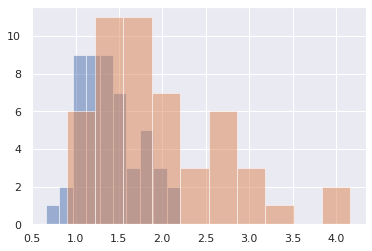

In [3]:
dat.groupby('GOLD_Lesions').FLAIR.hist(alpha= .5)

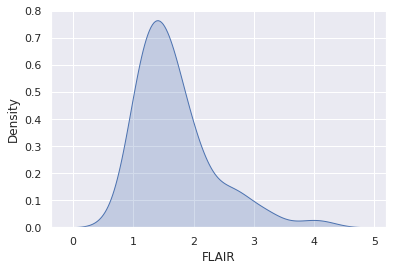

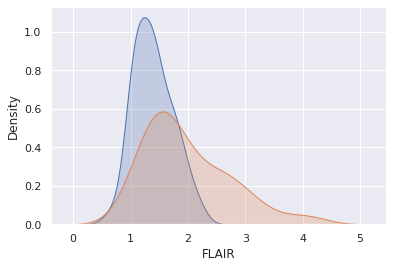

In [4]:

x0 = dat.FLAIR[dat.GOLD_Lesions == 0]
x1 = dat.FLAIR[dat.GOLD_Lesions == 1]
x2 = dat.FLAIR


sns.kdeplot(x2, shade = True, label = 'Marginal')

plt.show()

sns.kdeplot(x0, shade = True, label = 'Gold Std = 0')
sns.kdeplot(x1, shade = True, label = 'Gold Std = 1')

plt.show()




# Classification

Let's try creating the simplest possible classifier, a threshold. So here we want to pick the value of the threshold so that lower values are classified `GOLD_Lesion == 0` (i.e. no lesion) and higher values are `GOLD_Lesion == 1` (lesion at this voxel). We want to do this on labeled voxels so that we can pick a meaningful threshold on voxels without a gold standard labeling. That is, for new patients we want to automatically label their images one voxel at a time with a simple thresholding rule. We're going to use our **training data** where we know the truth to develop the threshold. 

*Note the idea behind doing this is only useful if the new images without the gold standard are in the same units as the old one, which is not usually the case for MRIs. The technique for trying to make images comparable is called normalization*. 

Let's first just try each of the datapoints itself as a threshold and pick which one does best.
However, I'm going to break the data into a training and testing set. The reason for this is that I want to make sure that I don't overfit. That is, we're going to test our algorithm on a dataset that wasn't used to train the algorithm. 


In [5]:
x = dat.FLAIR
y = dat.GOLD_Lesions
n = len(x)
trainFraction = .75

## Build a training and testing set
## Prob of being in the train set is trainFraction
sample = np.random.uniform(size = n) < trainFraction

## Get the training and testing sets
xtrain = x[ sample]
ytrain = y[ sample]
xtest =  x[~sample]
ytest =  y[~sample]



In [6]:
## Starting values, just set it to 
## 0 so that it improves on the first
## try
bestAccuracySoFar = 0

for t in np.sort(xtrain):
  ## Strictly greater than the threshold is
  ## our algorithm
  predictions = (xtrain > t)
  accuracy = np.mean(ytrain == predictions)
  if (accuracy > bestAccuracySoFar):
    bestThresholdSoFar = t 
    bestAccuracySoFar = accuracy 

threshold = bestThresholdSoFar
  

Now let's test our our "algorithm", on the test set. We'll look at the test set accuracy, but also how it breaks up into the sensisitivity and specificity.

## Definitions
test set **accuracy** = proportion of correct classifications on the test data

test set **sensitivity** = proportion declared diseased among those that are actually diseased. (In this case lesion = disease)

test set **specificity** = proportion declared not diseased among those that are actually not diseased.

To interpret the sensitivity and specificity, imagine setting the threshold nearly to zero. Then we'll declare almost every voxel a lesion and we'll have nearly 100% sensitivity and nearly 0% specificity. If we declare a voxel as a lesion it's not that interesting. If we declare a voxel as not lesions, then it's probably not a lesion.

If we set the threshold really high, then we'll have nearly 0% sensitivity and 100% specificity. If we say a voxel is not lesioned, it's not that informative, since we declare nearly everything not a lesion. But if we declare a voxel a lesion, it usually is.


So, if you have a high sensitivity, it's good for ruling diseases out. If you have a high specificity it's good for ruling diseases in. If you have a high both? Then you have a very good test.



In [7]:
## Let's test it out on the test set
testPredictions = (xtest > threshold)

## The test set accuracy
testAccuracy = np.mean(testPredictions == ytest)

## Let's see how it specifically does on the
## set of instances where ytest == 0 and ytest == 1
## The % it gets correct on ytest == 0 is called
## the specificity and the percent correct when 
## ytest == 1 is called the sensitivity.
sub0 = ytest == 0
sub1 = ytest == 1

testSpec = np.mean(ytest[sub0] == testPredictions[sub0])
testSens = np.mean(ytest[sub1] == testPredictions[sub1])

pd.DataFrame({
 
 'Threshold': threshold,
 'Accuracy': testAccuracy, 
 'Specificity': testSpec, 
 'Sensitivity': testSens}, index = [0])




,Threshold,Accuracy,Specificity,Sensitivity
0,1.419322,0.785714,0.733333,0.846154


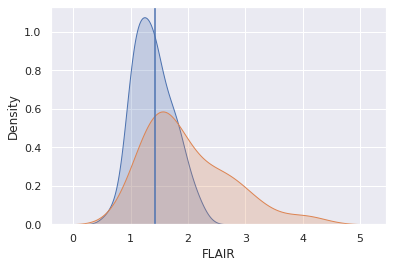

In [8]:
sns.kdeplot(x0, shade = True, label = 'Gold Std = 0')
sns.kdeplot(x1, shade = True, label = 'Gold Std = 1')
plt.axvline(x=threshold)
            
plt.show()


OK, so out plot has better sensitivity than specificity and a test set accuracy of around 68%. The lower specificity is because there's a lower percentage of blue below the line than orange above the line. Recall,  we're saying above the threshold is a lesion and orange is the distribution for voxels with lesions.

So, for this algorithm, the high sensitivity says that all else being equal, if you declare a voxel as not being a lesion, it probably isn't. In other words, if you're out in the lower part of the orange distribution, there's a lot of blue there.

However, all else isn't equal. Most voxels aren't lesions. This factors into our discussion in a way that we'll discuss later.



In [9]:
fpr, tpr, thresholds = roc_curve(ytest, xtest)
roc_auc = auc(fpr, tpr)

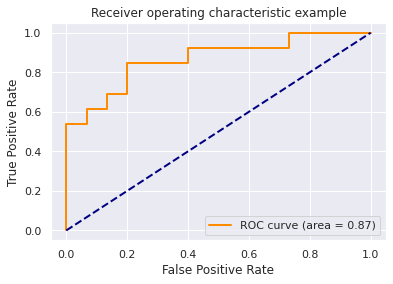

In [10]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()